## Combi rna_S3.1_cluster_allcells_clean

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy

sc.set_figure_params(figsize=(4, 4))
def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)
    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/cluster_clean/'

## Combi
### Read in raw counts dataset from removed 'lowQC', 'doublets' cluster object

In [2]:
adata = sc.read('S3_rna_cluster_annotate_1_clean.h5ad')
adata.X.shape

(37974, 35220)

In [3]:
adata

AnnData object with n_obs × n_vars = 37974 × 35220
    obs: 'sample', 'stage', 'donor_id', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'n_genes_by_counts', 'total_counts', 'total_counts_hum', 'pct_counts_hum', 'total_counts_pf', 'pct_counts_pf', 'stage_0', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'is_doublet_0.05', 'sample_barcode', 'assignment', 'leiden', 'MFidentity', 'cluster'
    var: 'gene_ids', 'feature_types', 'n_cells', 'hum', 'pf', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'MFidentity_colors', 'assignment_colors', 'cluster_colors', 'donor_id_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'phase_colors', 'rank_genes_groups', 'sample_colors', 'stage_0_colors', 'stage_c

In [4]:
adata.obs['donor_id'].value_counts()

Hrv107    25408
Hrv124    12566
Name: donor_id, dtype: int64

In [5]:
adata.obs['cluster'].value_counts()

F1                 18195
SCT                 6018
HBs+dNKs+Tcells     5831
Endo_f              2750
VCT_EPCAM_ITGA6     1753
M3+dM1              1391
EVT_HLAG            1364
Erythr               583
parasites_2D9         70
CD69_PTPRChi          19
Name: cluster, dtype: int64

In [6]:
sc.pp.filter_genes(adata, min_counts=3)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


#Remove cc genes
#ccgs defined in M1
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

##  Identify HVGs

In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3",
    batch_key="donor_id"
)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [8]:
# subset object for latter
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

## Normalize optional==optional

## Load latent space scVI from rna_S2_integrate_scVI_sc_clean


In [9]:
# n_latent_value 10
X_scVI = pd.read_csv('/lustre/scratch117/cellgen/team292/rh26/16_explant_sc_2D9_stars_combine/sc_combi_scVI_clean2/20220418_sc_combi_clean2_obsm_with_scVI_latent_representation_n_10_corrected_by_donor.csv', index_col=0)
adata.obsm["X_scVI"] = X_scVI.to_numpy()

## Clustering

In [10]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

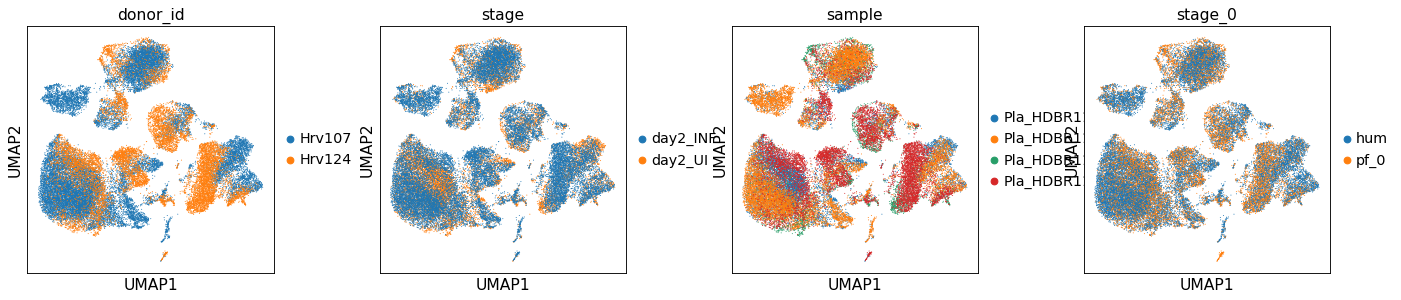

In [11]:
sc.pl.umap(
    adata,
    color=['donor_id',  'stage', 'sample', 'stage_0'],frameon=True, wspace = 0.3, save='_scVI_n_10_clean.pdf'
)

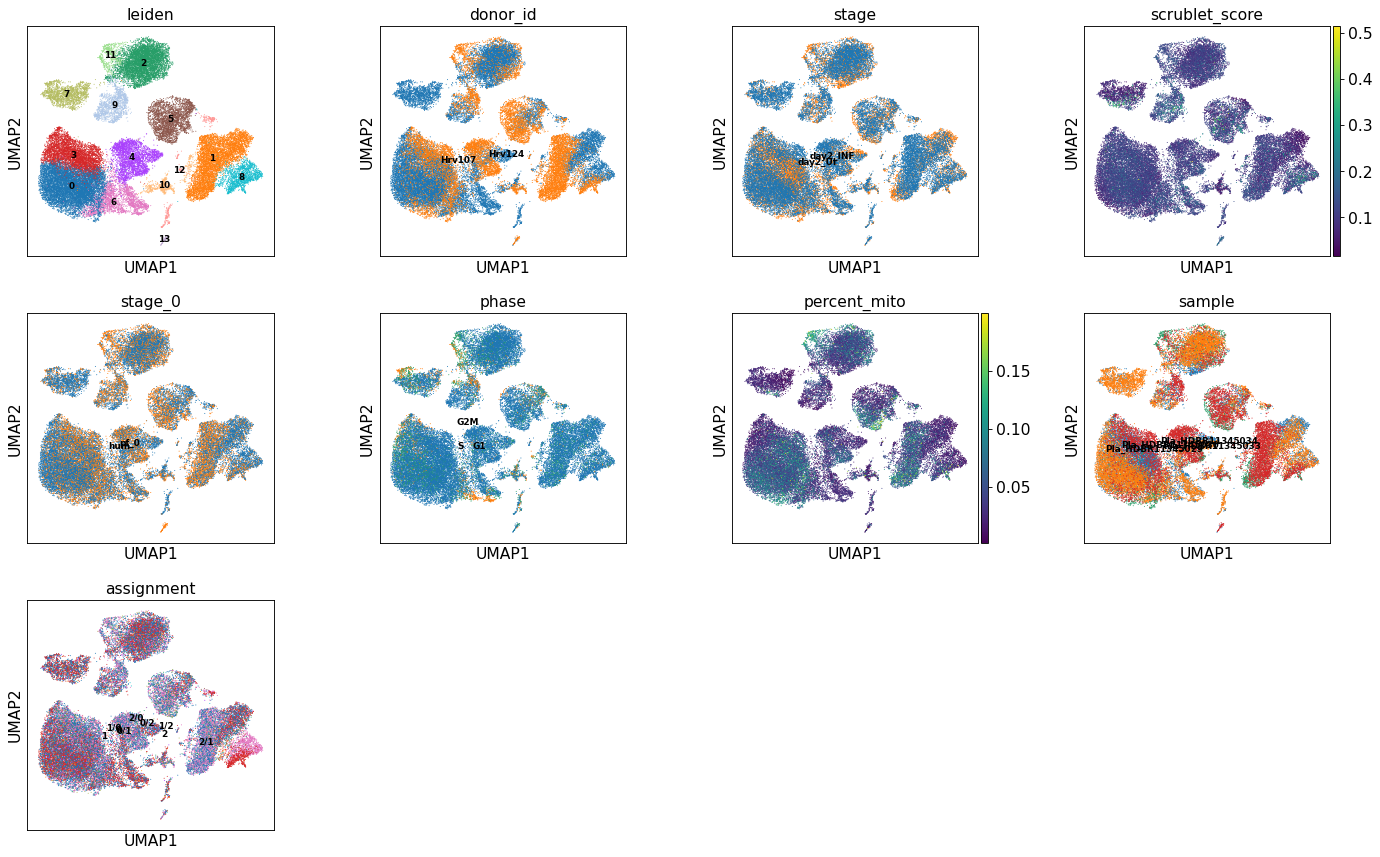

In [12]:
sc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(
    adata,
    color=['leiden', 'donor_id', 'stage', 'scrublet_score', 'stage_0', 'phase', 'percent_mito', 'sample', 'assignment'], legend_loc='on data',legend_fontsize=8,
    frameon=True,  wspace = 0.3
)

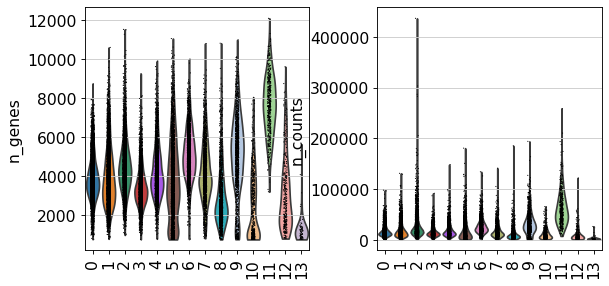

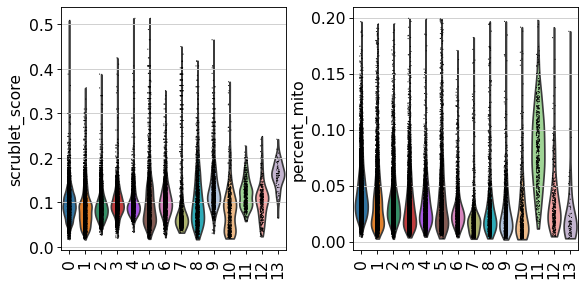

In [13]:
# identify lowQC
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='leiden', rotation=90, save='1_.pdf')
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='leiden', rotation=90, save='2_.pdf')

In [14]:
list(np.unique(adata.obs['MFidentity'])) 
adata.obs['MFidentity'].value_counts()

Fetal          32207
MF_doublets     4222
Maternal        1545
Name: MFidentity, dtype: int64

In [15]:
adata.obs['leiden'].value_counts()

0     8419
1     5523
2     5478
3     4407
4     2807
5     2776
6     2367
7     1749
8     1523
9     1422
10     619
11     489
12     325
13      70
Name: leiden, dtype: int64

In [16]:
adata.obs['cluster'].value_counts()

F1                 18195
SCT                 6018
HBs+dNKs+Tcells     5831
Endo_f              2750
VCT_EPCAM_ITGA6     1753
M3+dM1              1391
EVT_HLAG            1364
Erythr               583
parasites_2D9         70
CD69_PTPRChi          19
Name: cluster, dtype: int64

In [17]:
#Check
adata.obs.tail()

,sample,stage,donor_id,percent_mito,n_counts,n_genes,batch,low_ncounts,high_mito,low_ncounts_high_mito,...,zscore,bh_pval,bonf_pval,is_doublet,is_doublet_0.05,sample_barcode,assignment,leiden,MFidentity,cluster
Pla_HDBR11345034_TTTGTTGGTATTTCCT,Pla_HDBR11345034,day2_INF,Hrv124,0.003974,14091.0,3207,3,False,False,False,...,1.685866,0.387399,1.0,False,False,Pla_HDBR11345034_TTTGTTGGTATTTCCT,0,9,Fetal,EVT_HLAG
Pla_HDBR11345034_TTTGTTGGTGGAGAAA,Pla_HDBR11345034,day2_INF,Hrv124,0.069981,19934.0,4962,3,False,False,False,...,0.128607,0.927854,1.0,False,False,Pla_HDBR11345034_TTTGTTGGTGGAGAAA,0,1,Fetal,HBs+dNKs+Tcells
Pla_HDBR11345034_TTTGTTGGTGTTTGCA,Pla_HDBR11345034,day2_INF,Hrv124,0.048871,18907.0,4645,3,False,False,False,...,-1.532468,1.000000,1.0,False,False,Pla_HDBR11345034_TTTGTTGGTGTTTGCA,2,1,Fetal,HBs+dNKs+Tcells
Pla_HDBR11345034_TTTGTTGTCCTGGGAC,Pla_HDBR11345034,day2_INF,Hrv124,0.025543,15151.0,3834,3,False,False,False,...,0.128607,0.927854,1.0,False,False,Pla_HDBR11345034_TTTGTTGTCCTGGGAC,2,4,Fetal,F1
Pla_HDBR11345034_TTTGTTGTCGTAGAGG,Pla_HDBR11345034,day2_INF,Hrv124,0.021450,21259.0,4289,3,False,False,False,...,0.395032,0.927854,1.0,False,False,Pla_HDBR11345034_TTTGTTGTCGTAGAGG,0,3,Fetal,F1


/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


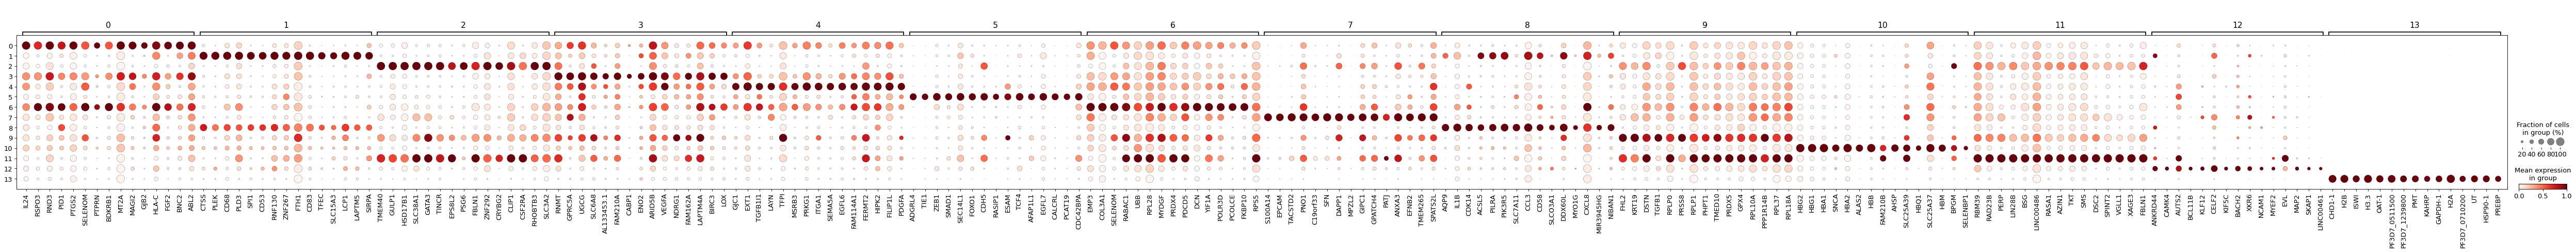

In [18]:
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=15, dendrogram=False, use_raw = False, standard_scale = 'var')

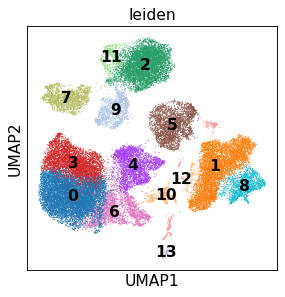

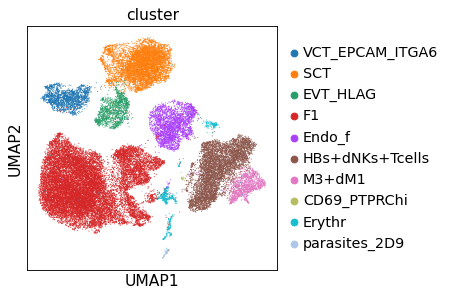

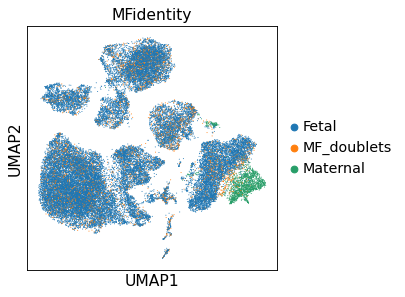

In [19]:
sc.pl.umap(adata, color=['leiden'],legend_loc='on data')
sc.pl.umap(adata, color=['cluster'])
sc.pl.umap(adata, color=['MFidentity'])

## Plot know marker_genes checking the clusters

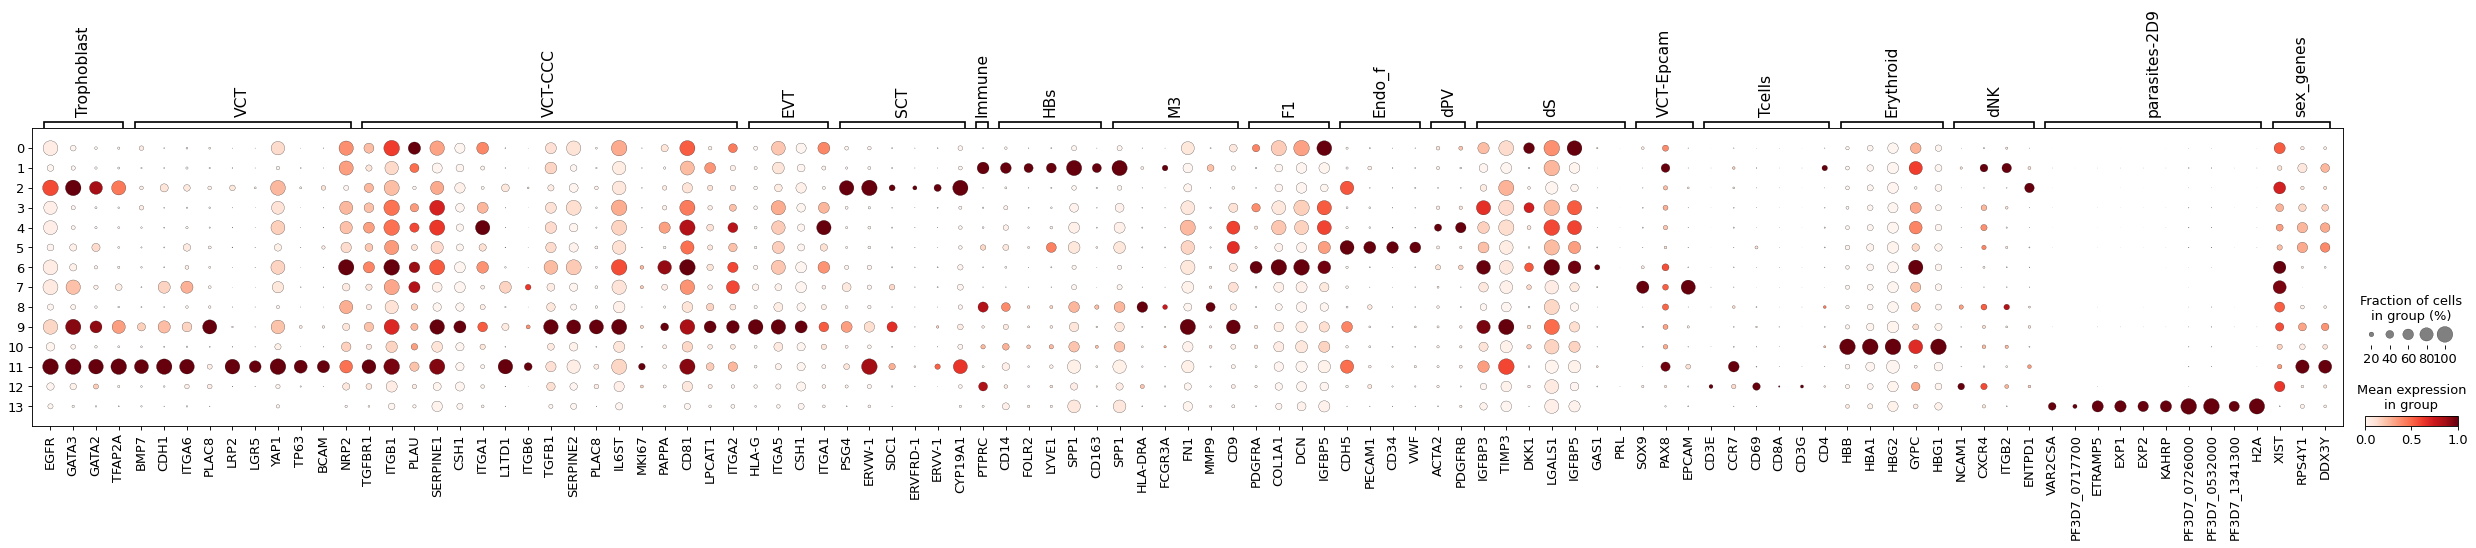

In [20]:
marker_genes = {
    'Trophoblast': {'GATA2', 'GATA3', 'TFAP2A', 'EGFR'},
    'VCT': {'TP63','ITGA6', 'LRP2', 'NRP2', 'BCAM', 'PLAC8', 'LGR5', 'YAP1', 'CDH1', 'BMP7'}, 
    'VCT-CCC': {'L1TD1', 'PLAC8','LPCAT1', 'SERPINE1', 'SERPINE2', 'PLAU','ITGB1', 'ITGB6','IL6ST', 'ITGA1', 'ITGA2','CD81','MKI67', 'CSH1', 'TGFB1', 'TGFBR1','PAPPA'},
    'EVT': {'HLA-G', 'CSH1', 'ITGA5', 'ITGA1'},
    'SCT':{'CYP19A1','PSG4', 'SDC1', 'ERVFRD-1','ERVW-1', 'ERVV-1' },
    'Immune':{'PTPRC'},
    'HBs':{'LYVE1', 'FOLR2','SPP1', 'CD14', 'CD163'},
    'M3':{'CD9', 'SPP1','HLA-DRA', 'FCGR3A', 'FN1', 'MMP9'},
    'F1':{'DCN','IGFBP5', 'PDGFRA','COL1A1'},
    'Endo_f': {'CD34','PECAM1', 'CDH5', 'VWF'},
    'dPV': {'PDGFRB', 'ACTA2'},
    'dS': {'IGFBP3', 'PRL','DKK1', 'GAS1', 'IGFBP5', 'LGALS1', 'TIMP3'},
    'VCT-Epcam': {"EPCAM", 'PAX8', 'SOX9'},
    'Tcells': {"CD4",'CD3E', 'CD3G', 'CD69', 'CCR7', 'CD8A'},
    'Erythroid': {"GYPC", "HBA1", 'HBB', 'HBG2','HBG1'},
    'dNK':{'NCAM1', 'ENTPD1','ITGB2', 'CXCR4'},#, 'CD39=ENTPD1',
    'parasites-2D9':{'VAR2CSA', 'EXP1', 'EXP2', 'ETRAMP5','KAHRP','PF3D7_0726000','PF3D7_0532000', 'H2A',  'PF3D7_0717700','PF3D7_1341300'},
    'sex_genes':{'RPS4Y1','DDX3Y', 'XIST',}
}
sc.pl.dotplot(adata, marker_genes, groupby='leiden', use_raw=False, standard_scale = 'var')

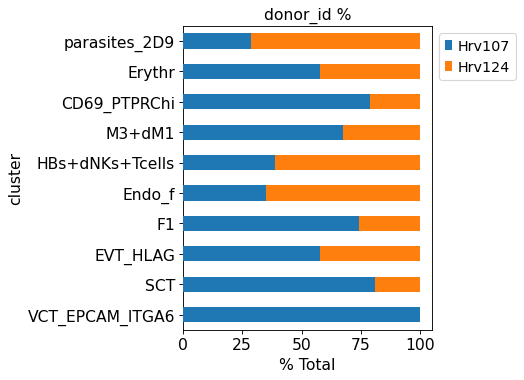

In [21]:
def Barplot(which_var, adata, var='cluster', height=5, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False,)
    else: 
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_xlabel('% Total')
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', dpi=300, orientation='landscape', format= 'pdf',  bbox_inches='tight')
Barplot('donor_id', adata)

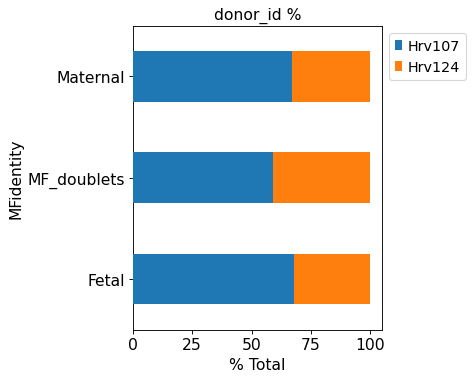

In [22]:
def Barplot(which_var, adata, var='MFidentity', height=5, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False,)
    else: 
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_xlabel('% Total')
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', dpi=300, orientation='landscape', format= 'pdf',  bbox_inches='tight')
Barplot('donor_id', adata)

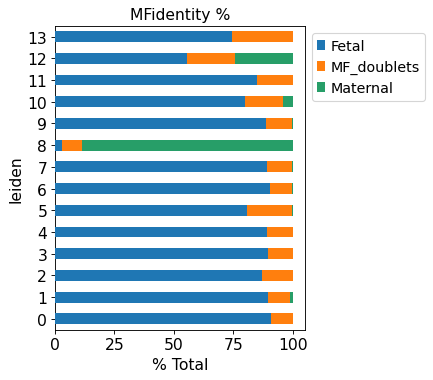

In [23]:
def Barplot(which_var, adata, var='leiden', height=5, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False,)
    else: 
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_xlabel('% Total')
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', dpi=300, orientation='landscape', format= 'pdf',  bbox_inches='tight')
Barplot('MFidentity', adata)

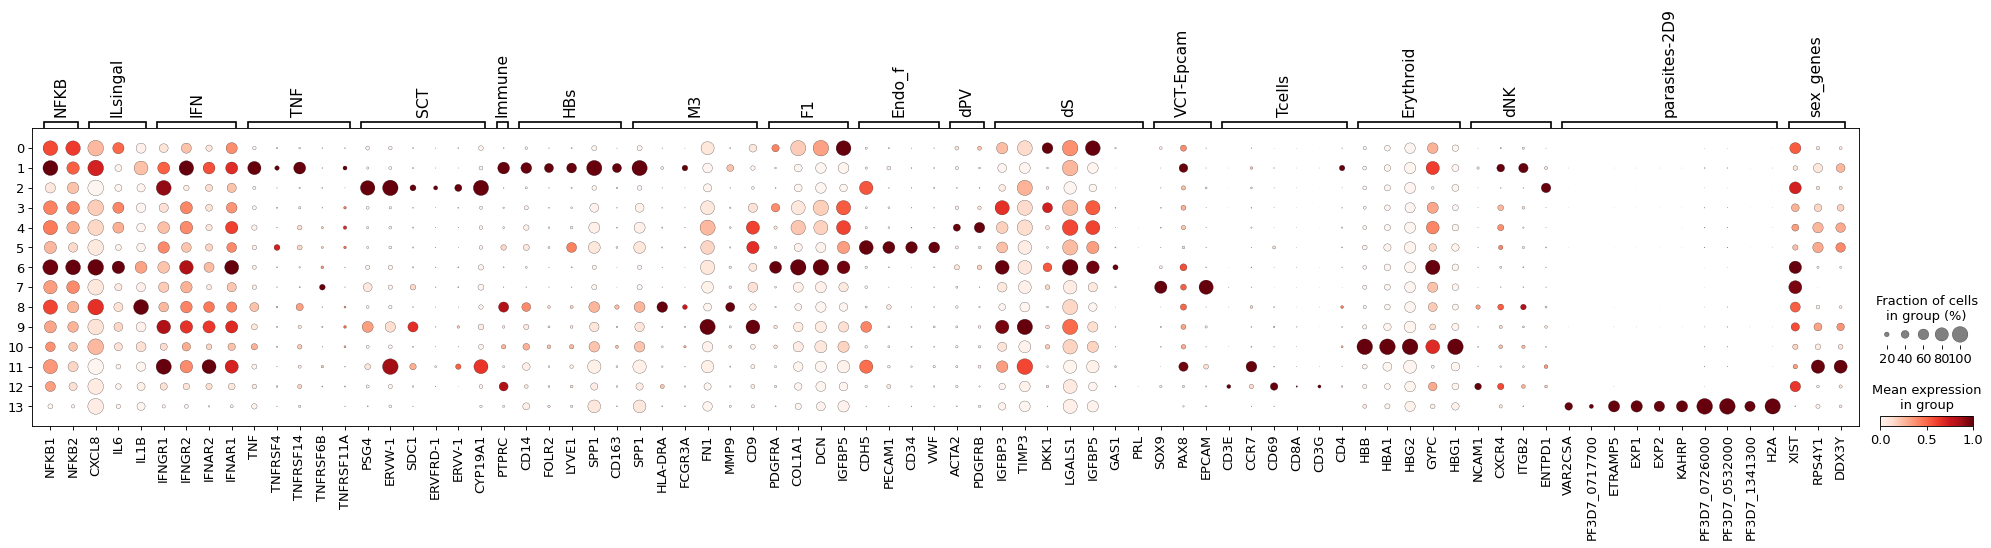

In [24]:
inflamm_genes = {
    'NFKB': {'NFKB1', 'NFKB2'},
    'ILsingal': {'CXCL8','IL1B', 'IL6'}, 
    'IFN': {'IFNGR1','IFNGR2','IFNAR2', 'IFNAR1'},
    'TNF': {'TNFRSF4','TNFRSF14','TNFRSF11A', 'TNFRSF6B', 'TNF'},
    'SCT':{'CYP19A1','PSG4', 'SDC1', 'ERVFRD-1','ERVW-1', 'ERVV-1' },
    'Immune':{'PTPRC'},
    'HBs':{'LYVE1', 'FOLR2','SPP1', 'CD14', 'CD163'},
    'M3':{'CD9', 'SPP1','HLA-DRA', 'FCGR3A', 'FN1', 'MMP9'},
    'F1':{'DCN','IGFBP5', 'PDGFRA','COL1A1'},
    'Endo_f': {'CD34','PECAM1', 'CDH5', 'VWF'},
    'dPV': {'PDGFRB', 'ACTA2'},
    'dS': {'IGFBP3', 'PRL','DKK1', 'GAS1', 'IGFBP5', 'LGALS1', 'TIMP3'},
    'VCT-Epcam': {"EPCAM", 'PAX8', 'SOX9'},
    'Tcells': {"CD4",'CD3E', 'CD3G', 'CD69', 'CCR7', 'CD8A'},
    'Erythroid': {"GYPC", "HBA1", 'HBB', 'HBG2','HBG1'},
    'dNK':{'NCAM1', 'ENTPD1','ITGB2', 'CXCR4'},#, 'CD39=ENTPD1',
    'parasites-2D9':{'VAR2CSA', 'EXP1', 'EXP2', 'ETRAMP5','KAHRP','PF3D7_0726000','PF3D7_0532000', 'H2A',  'PF3D7_0717700','PF3D7_1341300'},
    'sex_genes':{'RPS4Y1','DDX3Y', 'XIST',}
}
sc.pl.dotplot(adata, inflamm_genes, groupby='leiden', use_raw=False, standard_scale = 'var')

In [25]:
adata

AnnData object with n_obs × n_vars = 37974 × 34830
    obs: 'sample', 'stage', 'donor_id', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'n_genes_by_counts', 'total_counts', 'total_counts_hum', 'pct_counts_hum', 'total_counts_pf', 'pct_counts_pf', 'stage_0', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'is_doublet_0.05', 'sample_barcode', 'assignment', 'leiden', 'MFidentity', 'cluster'
    var: 'gene_ids', 'feature_types', 'n_cells', 'hum', 'pf', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'MFidentity_colors', 'assignment_colors', 'cluster_colors', 'donor_id_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'phase_colors', 'rank_genes_groups', 'sample_colors', 'stage_0_colors', 'stage_c

## Save adata with new leiden clusters info for logistic regression 

In [26]:
adata.write('S3_rna_cluster_annotate_1_clean.h5ad')
adata.obs.to_csv('S3_rna_cluster_annotate_1_clean.csv')

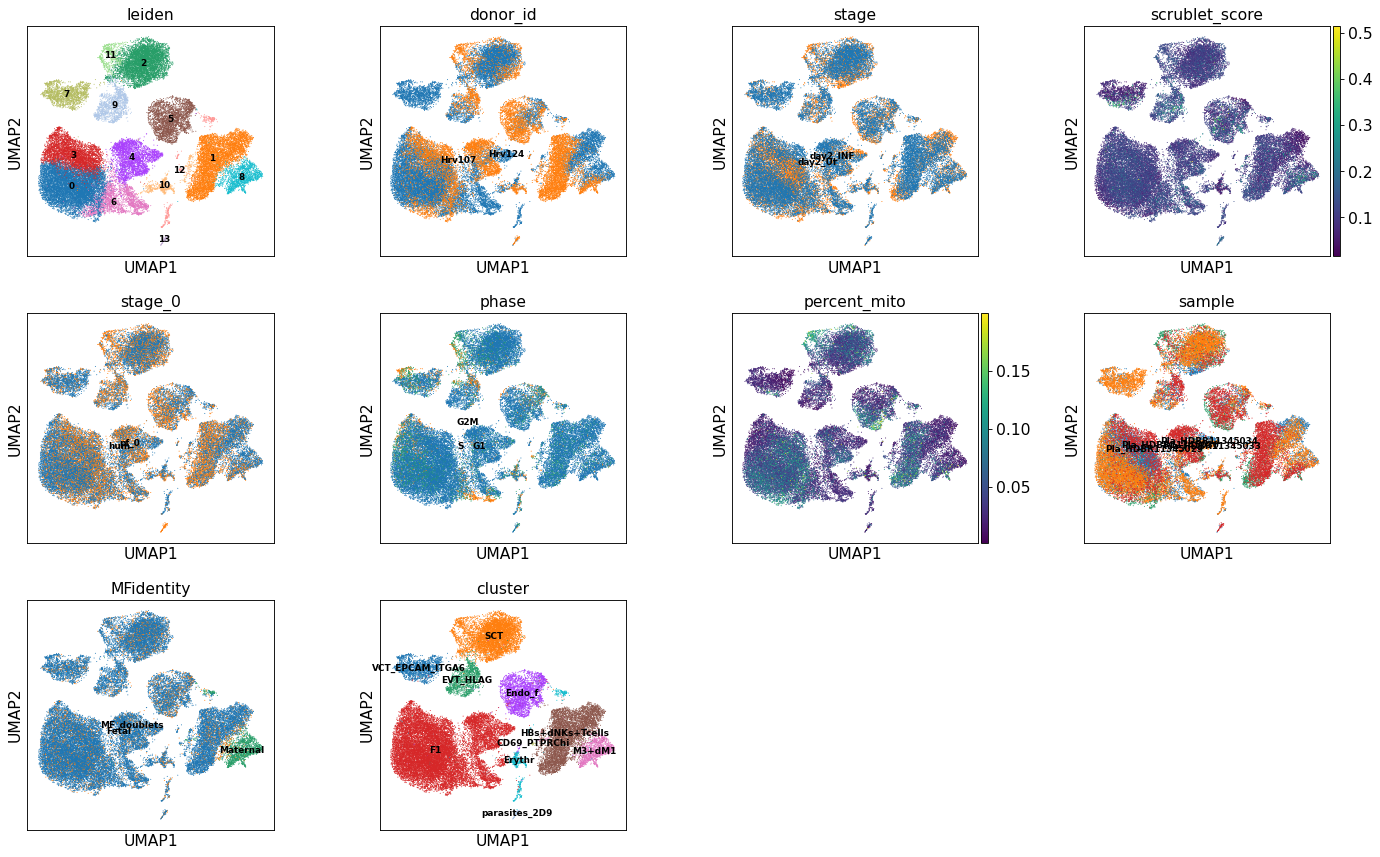

In [27]:
sc.pl.umap(
    adata,
    color=['leiden', 'donor_id', 'stage', 'scrublet_score', 'stage_0', 'phase', 'percent_mito', 'sample', 'MFidentity', 'cluster'], legend_loc='on data',legend_fontsize=8,
    frameon=True,  wspace = 0.3, save='_summary_clean.pdf'
)